In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Bokeh_data/Training.zip

**TENSORFLOW**

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split 
import imageio
import os 
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model

**DataLoad**

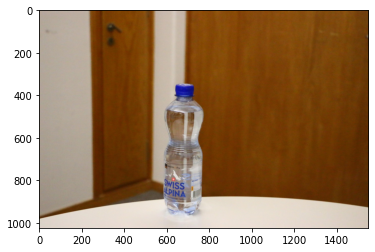

In [ ]:
trial_img= cv2.imread('bokeh/0.jpg')
trial_img = cv2.cvtColor(trial_img, cv2.COLOR_BGR2RGB)
plt.imshow(trial_img)

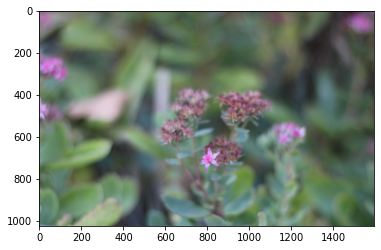

In [ ]:
# ytrain_img=[0]*200
# for i in range(200):
#   ytrain_img[i] = cv2.imread('bokeh/'+str(i)+'.jpg') #array size define else append , direct i cant put
#   ytrain_img[i] = cv2.cvtColor(ytrain_img[i], cv2.COLOR_BGR2RGB)
# plt.imshow(ytrain_img[3])  
# ytest_img=[0]*50
# for i in range(250,300):
#   ytest_img[i-250] = cv2.imread('bokeh/'+str(i)+'.jpg') 
#   ytest_img[i-250] = cv2.cvtColor(ytest_img[i-250], cv2.COLOR_BGR2RGB)
# plt.imshow(ytest_img[17]) 

In [ ]:
#resize the image
IMG_height= 512
IMG_width=512

In [ ]:
ytrain_img=[0]*200
ytest_img=[0]*51
for i in range(200):
  ytrain_img[i] = cv2.imread('bokeh/'+str(i)+'.jpg') #array size define else append , direct i cant put
  ytrain_img[i] = cv2.cvtColor(ytrain_img[i], cv2.COLOR_BGR2RGB)
  ytrain_img[i] = cv2.resize(ytrain_img[i], (IMG_height,IMG_width), interpolation = cv2.INTER_AREA)
  ytrain_img[i] = np.array(ytrain_img[i])
  ytrain_img[i] = ytrain_img[i].astype('float32') 
  ytrain_img[i] /=255 
for i in range(250,300):
  ytest_img[i-250] = cv2.imread('bokeh/'+str(i)+'.jpg') #array size define else append , direct i cant put
  ytest_img[i-250] = cv2.cvtColor(ytest_img[i-250], cv2.COLOR_BGR2RGB)
  ytest_img[i-250] = cv2.resize(ytest_img[i-250], (IMG_height,IMG_width), interpolation = cv2.INTER_AREA)
  ytest_img[i-250] = np.array(ytest_img[i-250])
  ytest_img[i-250] = ytest_img[i-250].astype('float32') 
  ytest_img[i-250] /=255

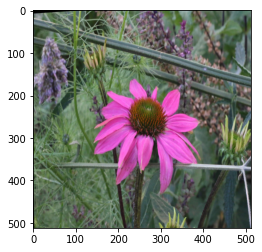

In [ ]:
train_img=[0]*200
test_img=[0]*51
for i in range(200):
  train_img[i] = cv2.imread('original/'+str(i)+'.jpg') #array size define else append , direct i cant put
  train_img[i] = cv2.cvtColor(train_img[i], cv2.COLOR_BGR2RGB)
  train_img[i] = cv2.resize(train_img[i], (IMG_height,IMG_width), interpolation = cv2.INTER_AREA)
  train_img[i] = np.array(train_img[i])
  train_img[i] = train_img[i].astype('float32') 
  train_img[i] /=255 
for i in range(250,300):
  test_img[i-250] = cv2.imread('original/'+str(i)+'.jpg') #array size define else append , direct i cant put
  test_img[i-250] = cv2.cvtColor(test_img[i-250], cv2.COLOR_BGR2RGB)
  test_img[i-250] = cv2.resize(test_img[i-250], (IMG_height,IMG_width), interpolation = cv2.INTER_AREA)
  test_img[i-250] = np.array(test_img[i-250])
  test_img[i-250] = test_img[i-250].astype('float32') 
  test_img[i-250] /=255
plt.imshow(train_img[3])  
plt.imshow(test_img[48])

# #cant directly put image in model - np array 
# # img read then -- update the for loop above
# image= cv2.resize(image, (IMG_height,IMG-width), interpolation = cv2.INTER_AREA)
# image= np.array(image)
# image= image.astype('float32')

# #normalise the pixel array
# image /=255  # or 512

In [ ]:
train_img= np.array(train_img)
ytrain_img= np.array(ytrain_img)
test_img= np.array(test_img)
ytest_img= np.array(ytest_img)

In [ ]:
print(train_img)

In [ ]:
print(ytrain_img[1].shape)

**Model**

In [18]:
#Hyperparameters

batch_size2 = 10
learning_rate = 0.001
num_epochs = 5
instance_norm= True
instance_norm_level_1= False 

In [21]:
import tensorflow as tf
import numpy as np

inputs= Input(shape=(IMG_height,IMG_width,3),batch_size=batch_size2)
#vaha old tf version - copy paste wont work


def PyNET(input, instance_norm=True, instance_norm_level_1=False):

    # Note: the paper uses a different layer naming scheme.
    # In this code, layer N corresponds to layer N+2 from the article.

    with tf.compat.v1.variable_scope("generator"):

        # -----------------------------------------
        # Space-to-depth layer

        space2depth_l0 = tf.nn.space_to_depth(input, 2)                                         # 512 -> 256

        # -----------------------------------------
        # Downsampling layers

        conv_l1_d1 = _conv_multi_block(space2depth_l0, 3, num_maps=32, instance_norm=False)     # 256 -> 256
        pool1 = max_pool(conv_l1_d1, 2)                                                         # 256 -> 128

        conv_l2_d1 = _conv_multi_block(pool1, 3, num_maps=64, instance_norm=instance_norm)      # 128 -> 128
        pool2 = max_pool(conv_l2_d1, 2)                                                         # 128 -> 64

        conv_l3_d1 = _conv_multi_block(pool2, 3, num_maps=128, instance_norm=instance_norm)     # 64 -> 64
        pool3 = max_pool(conv_l3_d1, 2)                                                         # 64 -> 32

        conv_l4_d1 = _conv_multi_block(pool3, 3, num_maps=256, instance_norm=instance_norm)     # 32 -> 32
        pool4 = max_pool(conv_l4_d1, 2)                                                         # 32 -> 16

        # -----------------------------------------
        # Processing: Level 5,  Input size: 16 x 16

        conv_l5_d1 = _conv_multi_block(pool4, 3, num_maps=512, instance_norm=instance_norm)
        conv_l5_d2 = _conv_multi_block(conv_l5_d1, 3, num_maps=512, instance_norm=instance_norm) + conv_l5_d1
        conv_l5_d3 = _conv_multi_block(conv_l5_d2, 3, num_maps=512, instance_norm=instance_norm) + conv_l5_d2
        conv_l5_d4 = _conv_multi_block(conv_l5_d3, 3, num_maps=512, instance_norm=instance_norm)

        conv_t4a = _conv_tranpose_layer(conv_l5_d4, 256, 3, 2)      # 16 -> 32
        conv_t4b = _conv_tranpose_layer(conv_l5_d4, 256, 3, 2)      # 16 -> 32

        # -> Output: Level 5

        conv_l5_out = _conv_layer(conv_l5_d4, 3, 3, 1, relu=False, instance_norm=False)
        output_l5 = tf.nn.tanh(conv_l5_out) * 0.58 + 0.5

        # -----------------------------------------
        # Processing: Level 4,  Input size: 32 x 32

        conv_l4_d2 = stack(conv_l4_d1, conv_t4a)
        conv_l4_d3 = _conv_multi_block(conv_l4_d2, 3, num_maps=256, instance_norm=instance_norm)
        conv_l4_d4 = _conv_multi_block(conv_l4_d3, 3, num_maps=256, instance_norm=instance_norm) + conv_l4_d3
        conv_l4_d5 = _conv_multi_block(conv_l4_d4, 3, num_maps=256, instance_norm=instance_norm) + conv_l4_d4
        conv_l4_d6 = stack(_conv_multi_block(conv_l4_d5, 3, num_maps=256, instance_norm=instance_norm), conv_t4b)

        conv_l4_d7 = _conv_multi_block(conv_l4_d6, 3, num_maps=256, instance_norm=instance_norm)

        conv_t3a = _conv_tranpose_layer(conv_l4_d7, 128, 3, 2)      # 32 -> 64
        conv_t3b = _conv_tranpose_layer(conv_l4_d7, 128, 3, 2)      # 32 -> 64

        # -> Output: Level 4

        conv_l4_out = _conv_layer(conv_l4_d7, 3, 3, 1, relu=False, instance_norm=False)
        output_l4 = tf.nn.tanh(conv_l4_out) * 0.58 + 0.5

        # -----------------------------------------
        # Processing: Level 3,  Input size: 64 x 64

        conv_l3_d2 = stack(conv_l3_d1, conv_t3a)
        conv_l3_d3 = _conv_multi_block(conv_l3_d2, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d2
        conv_l3_d4 = _conv_multi_block(conv_l3_d3, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d3
        conv_l3_d5 = _conv_multi_block(conv_l3_d4, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d4
        conv_l3_d6 = stack(_conv_multi_block(conv_l3_d5, 5, num_maps=128, instance_norm=instance_norm), conv_l3_d1)
        conv_l3_d7 = stack(conv_l3_d6, conv_t3b)

        conv_l3_d8 = _conv_multi_block(conv_l3_d7, 3, num_maps=128, instance_norm=instance_norm)

        conv_t2a = _conv_tranpose_layer(conv_l3_d8, 64, 3, 2)       # 64 -> 128
        conv_t2b = _conv_tranpose_layer(conv_l3_d8, 64, 3, 2)       # 64 -> 128

        # -> Output: Level 3

        conv_l3_out = _conv_layer(conv_l3_d8, 3, 3, 1, relu=False, instance_norm=False)
        output_l3 = tf.nn.tanh(conv_l3_out) * 0.58 + 0.5

        # -------------------------------------------
        # Processing: Level 2,  Input size: 128 x 128

        conv_l2_d2 = stack(conv_l2_d1, conv_t2a)
        conv_l2_d3 = stack(_conv_multi_block(conv_l2_d2, 5, num_maps=64, instance_norm=instance_norm), conv_l2_d1)

        conv_l2_d4 = _conv_multi_block(conv_l2_d3, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d3
        conv_l2_d5 = _conv_multi_block(conv_l2_d4, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d4
        conv_l2_d6 = _conv_multi_block(conv_l2_d5, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d5
        conv_l2_d7 = stack(_conv_multi_block(conv_l2_d6, 7, num_maps=64, instance_norm=instance_norm), conv_l2_d1)

        conv_l2_d8 = stack(_conv_multi_block(conv_l2_d7, 5, num_maps=64, instance_norm=instance_norm), conv_t2b)
        conv_l2_d9 = _conv_multi_block(conv_l2_d8, 3, num_maps=64, instance_norm=instance_norm)

        conv_t1a = _conv_tranpose_layer(conv_l2_d9, 32, 3, 2)       # 128 -> 256
        conv_t1b = _conv_tranpose_layer(conv_l2_d9, 32, 3, 2)       # 128 -> 256

        # -> Output: Level 2

        conv_l2_out = _conv_layer(conv_l2_d9, 3, 3, 1, relu=False, instance_norm=False)
        output_l2 = tf.nn.tanh(conv_l2_out) * 0.58 + 0.5

        # -------------------------------------------
        # Processing: Level 1,  Input size: 256 x 256

        conv_l1_d2 = stack(conv_l1_d1, conv_t1a)
        conv_l1_d3 = stack(_conv_multi_block(conv_l1_d2, 5, num_maps=32, instance_norm=False), conv_l1_d1)

        conv_l1_d4 = _conv_multi_block(conv_l1_d3, 7, num_maps=32, instance_norm=False)

        conv_l1_d5 = _conv_multi_block(conv_l1_d4, 9, num_maps=32, instance_norm=instance_norm_level_1)
        conv_l1_d6 = _conv_multi_block(conv_l1_d5, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d5
        conv_l1_d7 = _conv_multi_block(conv_l1_d6, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d6
        conv_l1_d8 = _conv_multi_block(conv_l1_d7, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d7

        conv_l1_d9 = stack(_conv_multi_block(conv_l1_d8, 7, num_maps=32, instance_norm=False), conv_l1_d1)

        conv_l1_d10 = stack(_conv_multi_block(conv_l1_d9, 5, num_maps=32, instance_norm=False), conv_t1b)
        conv_l1_d11 = stack(conv_l1_d10, conv_l1_d1)

        conv_l1_d12 = _conv_multi_block(conv_l1_d11, 3, num_maps=32, instance_norm=False)

        # -> Output: Level 1

        conv_l1_out = _conv_layer(conv_l1_d12, 3, 3, 1, relu=False, instance_norm=False)
        output_l1 = tf.nn.tanh(conv_l1_out) * 0.58 + 0.5

        # ----------------------------------------------------------
        # Processing: Level 0 (x2 upscaling),  Input size: 256 x 256

        conv_l0 = _conv_tranpose_layer(conv_l1_d12, 8, 3, 2)        # 256 -> 512
        conv_l0_out = _conv_layer(conv_l0, 3, 3, 1, relu=False, instance_norm=False)
        output_l0 = tf.nn.tanh(conv_l0_out) * 0.58 + 0.5

        # ----------------------------------------------------------
        # Processing: Level Up (x4 upscaling),  Input size: 512 x 512

        conv_l_up = _conv_tranpose_layer(conv_l0_out, 3, 3, 2)  # 512 -> 1024
        conv_l_up_out = _conv_layer(conv_l_up, 3, 3, 1, relu=False, instance_norm=False)

        output_l_up = tf.nn.tanh(conv_l_up_out) * 0.58 + 0.5

    return output_l_up, output_l0, output_l1, output_l2, output_l3, output_l4, output_l5


def _conv_multi_block(input, max_size, num_maps, instance_norm):

    conv_3a = _conv_layer(input, num_maps, 3, 1, relu=True, instance_norm=instance_norm)
    conv_3b = _conv_layer(conv_3a, num_maps, 3, 1, relu=True, instance_norm=instance_norm)

    output_tensor = conv_3b

    if max_size >= 5:

        conv_5a = _conv_layer(input, num_maps, 5, 1, relu=True, instance_norm=instance_norm)
        conv_5b = _conv_layer(conv_5a, num_maps, 5, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_5b)

    if max_size >= 7:

        conv_7a = _conv_layer(input, num_maps, 7, 1, relu=True, instance_norm=instance_norm)
        conv_7b = _conv_layer(conv_7a, num_maps, 7, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_7b)

    if max_size >= 9:

        conv_9a = _conv_layer(input, num_maps, 9, 1, relu=True, instance_norm=instance_norm)
        conv_9b = _conv_layer(conv_9a, num_maps, 9, 1, relu=True, instance_norm=instance_norm)

        output_tensor = stack(output_tensor, conv_9b)

    return output_tensor


def stack(x, y):
    return tf.concat([x, y], 3)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)


def _conv_layer(net, num_filters, filter_size, strides, relu=True, instance_norm=False, padding='SAME'):

    weights_init = _conv_init_vars(net, num_filters, filter_size)
    strides_shape = [1, strides, strides, 1]
    bias = tf.Variable(tf.constant(0.01, shape=[num_filters]))

    net = tf.nn.conv2d(net, weights_init, strides_shape, padding=padding) + bias

    if instance_norm:
        net = _instance_norm(net)

    if relu:
        net = leaky_relu(net)

    return net


def _instance_norm(net):

    batch, rows, cols, channels = [i for i in net.get_shape()]
    var_shape = [channels]

    mu, sigma_sq = tf.compat.v1.nn.moments(net, [1,2], keep_dims=True)
    shift = tf.Variable(tf.zeros(var_shape))
    scale = tf.Variable(tf.ones(var_shape))

    epsilon = 1e-3
    normalized = (net-mu)/(sigma_sq + epsilon)**(.5)

    return scale * normalized + shift


def _conv_init_vars(net, out_channels, filter_size, transpose=False):

    _, rows, cols, in_channels = [i for i in net.get_shape()]

    if not transpose:
        weights_shape = [filter_size, filter_size, in_channels, out_channels]
    else:
        weights_shape = [filter_size, filter_size, out_channels, in_channels]

    weights_init = tf.Variable(tf.compat.v1.truncated_normal(weights_shape, stddev=0.01, seed=1), dtype=tf.float32)
    return weights_init


def _conv_tranpose_layer(net, num_filters, filter_size, strides):
    weights_init = _conv_init_vars(net, num_filters, filter_size, transpose=True)

    net_shape = tf.shape(net)
    tf_shape = tf.stack([net_shape[0], net_shape[1] * strides, net_shape[2] * strides, num_filters])

    strides_shape = [1, strides, strides, 1]
    net = tf.nn.conv2d_transpose(net, weights_init, tf_shape, strides_shape, padding='SAME')

    return leaky_relu(net)


def max_pool(x, n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='VALID')

In [ ]:
space2depth_l0 = tf.nn.space_to_depth(inputs, 2)                                         # 512 -> 256

        # -----------------------------------------
        # Downsampling layers

conv_l1_d1 = _conv_multi_block(space2depth_l0, 3, num_maps=32, instance_norm=False)     # 256 -> 256
pool1 = max_pool(conv_l1_d1, 2)                                                         # 256 -> 128

conv_l2_d1 = _conv_multi_block(pool1, 3, num_maps=64, instance_norm=instance_norm)      # 128 -> 128
pool2 = max_pool(conv_l2_d1, 2)                                                         # 128 -> 64

conv_l3_d1 = _conv_multi_block(pool2, 3, num_maps=128, instance_norm=instance_norm)     # 64 -> 64
pool3 = max_pool(conv_l3_d1, 2)                                                         # 64 -> 32

conv_l4_d1 = _conv_multi_block(pool3, 3, num_maps=256, instance_norm=instance_norm)     # 32 -> 32
pool4 = max_pool(conv_l4_d1, 2)                                                         # 32 -> 16

        # -----------------------------------------
        # Processing: Level 5,  Input size: 16 x 16

conv_l5_d1 = _conv_multi_block(pool4, 3, num_maps=512, instance_norm=instance_norm)
conv_l5_d2 = _conv_multi_block(conv_l5_d1, 3, num_maps=512, instance_norm=instance_norm) + conv_l5_d1
conv_l5_d3 = _conv_multi_block(conv_l5_d2, 3, num_maps=512, instance_norm=instance_norm) + conv_l5_d2
conv_l5_d4 = _conv_multi_block(conv_l5_d3, 3, num_maps=512, instance_norm=instance_norm)

conv_t4a = _conv_tranpose_layer(conv_l5_d4, 256, 3, 2)      # 16 -> 32
conv_t4b = _conv_tranpose_layer(conv_l5_d4, 256, 3, 2)      # 16 -> 32

        # -> Output: Level 5

conv_l5_out = _conv_layer(conv_l5_d4, 3, 3, 1, relu=False, instance_norm=False)
output_l5 = tf.nn.tanh(conv_l5_out) * 0.58 + 0.5

        # -----------------------------------------
        # Processing: Level 4,  Input size: 32 x 32

conv_l4_d2 = stack(conv_l4_d1, conv_t4a)
conv_l4_d3 = _conv_multi_block(conv_l4_d2, 3, num_maps=256, instance_norm=instance_norm)
conv_l4_d4 = _conv_multi_block(conv_l4_d3, 3, num_maps=256, instance_norm=instance_norm) + conv_l4_d3
conv_l4_d5 = _conv_multi_block(conv_l4_d4, 3, num_maps=256, instance_norm=instance_norm) + conv_l4_d4
conv_l4_d6 = stack(_conv_multi_block(conv_l4_d5, 3, num_maps=256, instance_norm=instance_norm), conv_t4b)

conv_l4_d7 = _conv_multi_block(conv_l4_d6, 3, num_maps=256, instance_norm=instance_norm)

conv_t3a = _conv_tranpose_layer(conv_l4_d7, 128, 3, 2)      # 32 -> 64
conv_t3b = _conv_tranpose_layer(conv_l4_d7, 128, 3, 2)      # 32 -> 64

        # -> Output: Level 4

conv_l4_out = _conv_layer(conv_l4_d7, 3, 3, 1, relu=False, instance_norm=False)
output_l4 = tf.nn.tanh(conv_l4_out) * 0.58 + 0.5

        # -----------------------------------------
        # Processing: Level 3,  Input size: 64 x 64

conv_l3_d2 = stack(conv_l3_d1, conv_t3a)
conv_l3_d3 = _conv_multi_block(conv_l3_d2, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d2
conv_l3_d4 = _conv_multi_block(conv_l3_d3, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d3
conv_l3_d5 = _conv_multi_block(conv_l3_d4, 5, num_maps=128, instance_norm=instance_norm) + conv_l3_d4
conv_l3_d6 = stack(_conv_multi_block(conv_l3_d5, 5, num_maps=128, instance_norm=instance_norm), conv_l3_d1)
conv_l3_d7 = stack(conv_l3_d6, conv_t3b)

conv_l3_d8 = _conv_multi_block(conv_l3_d7, 3, num_maps=128, instance_norm=instance_norm)

conv_t2a = _conv_tranpose_layer(conv_l3_d8, 64, 3, 2)       # 64 -> 128
conv_t2b = _conv_tranpose_layer(conv_l3_d8, 64, 3, 2)       # 64 -> 128

        # -> Output: Level 3

conv_l3_out = _conv_layer(conv_l3_d8, 3, 3, 1, relu=False, instance_norm=False)
output_l3 = tf.nn.tanh(conv_l3_out) * 0.58 + 0.5

        # -------------------------------------------
        # Processing: Level 2,  Input size: 128 x 128

conv_l2_d2 = stack(conv_l2_d1, conv_t2a)
conv_l2_d3 = stack(_conv_multi_block(conv_l2_d2, 5, num_maps=64, instance_norm=instance_norm), conv_l2_d1)

conv_l2_d4 = _conv_multi_block(conv_l2_d3, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d3
conv_l2_d5 = _conv_multi_block(conv_l2_d4, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d4
conv_l2_d6 = _conv_multi_block(conv_l2_d5, 7, num_maps=64, instance_norm=instance_norm) + conv_l2_d5
conv_l2_d7 = stack(_conv_multi_block(conv_l2_d6, 7, num_maps=64, instance_norm=instance_norm), conv_l2_d1)

conv_l2_d8 = stack(_conv_multi_block(conv_l2_d7, 5, num_maps=64, instance_norm=instance_norm), conv_t2b)
conv_l2_d9 = _conv_multi_block(conv_l2_d8, 3, num_maps=64, instance_norm=instance_norm)

conv_t1a = _conv_tranpose_layer(conv_l2_d9, 32, 3, 2)       # 128 -> 256
conv_t1b = _conv_tranpose_layer(conv_l2_d9, 32, 3, 2)       # 128 -> 256

        # -> Output: Level 2

conv_l2_out = _conv_layer(conv_l2_d9, 3, 3, 1, relu=False, instance_norm=False)
output_l2 = tf.nn.tanh(conv_l2_out) * 0.58 + 0.5

        # -------------------------------------------
        # Processing: Level 1,  Input size: 256 x 256

conv_l1_d2 = stack(conv_l1_d1, conv_t1a)
conv_l1_d3 = stack(_conv_multi_block(conv_l1_d2, 5, num_maps=32, instance_norm=False), conv_l1_d1)

conv_l1_d4 = _conv_multi_block(conv_l1_d3, 7, num_maps=32, instance_norm=False)

conv_l1_d5 = _conv_multi_block(conv_l1_d4, 9, num_maps=32, instance_norm=instance_norm_level_1)
conv_l1_d6 = _conv_multi_block(conv_l1_d5, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d5
conv_l1_d7 = _conv_multi_block(conv_l1_d6, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d6
conv_l1_d8 = _conv_multi_block(conv_l1_d7, 9, num_maps=32, instance_norm=instance_norm_level_1) + conv_l1_d7

conv_l1_d9 = stack(_conv_multi_block(conv_l1_d8, 7, num_maps=32, instance_norm=False), conv_l1_d1)

conv_l1_d10 = stack(_conv_multi_block(conv_l1_d9, 5, num_maps=32, instance_norm=False), conv_t1b)
conv_l1_d11 = stack(conv_l1_d10, conv_l1_d1)

conv_l1_d12 = _conv_multi_block(conv_l1_d11, 3, num_maps=32, instance_norm=False)

        # -> Output: Level 1

conv_l1_out = _conv_layer(conv_l1_d12, 3, 3, 1, relu=False, instance_norm=False)
output_l1 = tf.nn.tanh(conv_l1_out) * 0.58 + 0.5

        # ----------------------------------------------------------
        # Processing: Level 0 (x2 upscaling),  Input size: 256 x 256

conv_l0 = _conv_tranpose_layer(conv_l1_d12, 8, 3, 2)        # 256 -> 512
conv_l0_out = _conv_layer(conv_l0, 3, 3, 1, relu=False, instance_norm=False)
output_l0 = tf.nn.tanh(conv_l0_out) * 0.58 + 0.5

        # ----------------------------------------------------------
        # Processing: Level Up (x4 upscaling),  Input size: 512 x 512

conv_l_up = _conv_tranpose_layer(conv_l0_out, 3, 3, 2)  # 512 -> 1024
conv_l_up_out = _conv_layer(conv_l_up, 3, 3, 1, relu=False, instance_norm=False)
output_l_up = tf.nn.tanh(conv_l_up_out) * 0.58 + 0.5

**Pre-Processing**

In [23]:
model= Model(inputs=inputs, outputs=output_l0, name="bokeh_model")
#input mei data kaha daala ?
#output is output lv1 ?

In [ ]:
model.summary()

**TRAIN**

In [ ]:
#Loss and Optimiser
optimizer0 = keras.optimizers.Adam(lr=learning_rate)
metrics0 = ["accuracy"]
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer0,metrics=metrics0)
model.fit(train_img, ytrain_img, batch_size=batch_size2, epochs=num_epochs, validation_split=0.2)

**EVALUATE**

In [ ]:
evaluation = model.evaluate(test_img, ytest_img, batch_size= batch_size2, verbose=2)
print("Test loss:", evaluation[0])
print("Test accuracy: %.1f%%" % (100.0 * evaluation[1]))

.


 .


**PyTORCH**

In [ ]:
path_to_dir = '/content/gdrive/MyDrive/'
!unzip gdrive/My\ Drive/Bokeh_data/Training.zip -d path_to_dir
input_data_directory= '/content/path_to_dir/bokeh'

In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn

In [ ]:
class LandmarkDataset(Dataset):
    def __init__(self, input_paths,output_paths, transform=False):
        self.image_paths = input_paths
        self.output_paths=output_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        #uniform prob-- almost all elements get covered
        image_filepath = os.join(self.image_paths,'/',idx)
        image_filepath=os.join(image_filepath,'.jpg')
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        path_output=os.join(self.output_paths,'/',idx)
        path_output=os.join(path_output,'.jpg')
        label = cv2.imread(path_output)
        #if self.transform is not None:
         #   image = self.transform(image=image)["image"]
        return image, label
    
#  Create Dataset

train_dataset = LandmarkDataset(train_image_paths,train_transforms)
valid_dataset = LandmarkDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(test_image_paths,test_transforms)

In [ ]:
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
class PyNET(nn.Module):

    def __init__(self, level, instance_norm=True, instance_norm_level_1=False):
        super(PyNET, self).__init__()

        self.level = level

        self.conv_l1_d1 = ConvMultiBlock(4, 32, 3, instance_norm=False)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv_l2_d1 = ConvMultiBlock(32, 64, 3, instance_norm=instance_norm)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv_l3_d1 = ConvMultiBlock(64, 128, 3, instance_norm=instance_norm)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv_l4_d1 = ConvMultiBlock(128, 256, 3, instance_norm=instance_norm)
        self.pool4 = nn.MaxPool2d(2, 2)

        # -------------------------------------

        self.conv_l5_d1 = ConvMultiBlock(256, 512, 3, instance_norm=instance_norm)
        self.conv_l5_d2 = ConvMultiBlock(512, 512, 3, instance_norm=instance_norm)
        self.conv_l5_d3 = ConvMultiBlock(512, 512, 3, instance_norm=instance_norm)
        self.conv_l5_d4 = ConvMultiBlock(512, 512, 3, instance_norm=instance_norm)

        self.conv_t4a = UpsampleConvLayer(512, 256, 3)
        self.conv_t4b = UpsampleConvLayer(512, 256, 3)

        self.conv_l5_out = ConvLayer(512, 3, kernel_size=3, stride=1, relu=False)
        self.output_l5 = nn.Sigmoid()

        # -------------------------------------

        self.conv_l4_d3 = ConvMultiBlock(512, 256, 3, instance_norm=instance_norm)
        self.conv_l4_d4 = ConvMultiBlock(256, 256, 3, instance_norm=instance_norm)
        self.conv_l4_d5 = ConvMultiBlock(256, 256, 3, instance_norm=instance_norm)
        self.conv_l4_d6 = ConvMultiBlock(256, 256, 3, instance_norm=instance_norm)
        self.conv_l4_d8 = ConvMultiBlock(512, 256, 3, instance_norm=instance_norm)

        self.conv_t3a = UpsampleConvLayer(256, 128, 3)
        self.conv_t3b = UpsampleConvLayer(256, 128, 3)

        self.conv_l4_out = ConvLayer(256, 3, kernel_size=3, stride=1, relu=False)
        self.output_l4 = nn.Sigmoid()

        # -------------------------------------

        self.conv_l3_d3 = ConvMultiBlock(256, 128, 5, instance_norm=instance_norm)
        self.conv_l3_d4 = ConvMultiBlock(256, 128, 5, instance_norm=instance_norm)
        self.conv_l3_d5 = ConvMultiBlock(256, 128, 5, instance_norm=instance_norm)
        self.conv_l3_d6 = ConvMultiBlock(256, 128, 5, instance_norm=instance_norm)
        self.conv_l3_d8 = ConvMultiBlock(512, 128, 3, instance_norm=instance_norm)

        self.conv_t2a = UpsampleConvLayer(128, 64, 3)
        self.conv_t2b = UpsampleConvLayer(128, 64, 3)

        self.conv_l3_out = ConvLayer(128, 3, kernel_size=3, stride=1, relu=False)
        self.output_l3 = nn.Sigmoid()

        # -------------------------------------

        self.conv_l2_d3 = ConvMultiBlock(128, 64, 5, instance_norm=instance_norm)
        self.conv_l2_d5 = ConvMultiBlock(192, 64, 7, instance_norm=instance_norm)
        self.conv_l2_d6 = ConvMultiBlock(192, 64, 7, instance_norm=instance_norm)
        self.conv_l2_d7 = ConvMultiBlock(192, 64, 7, instance_norm=instance_norm)
        self.conv_l2_d8 = ConvMultiBlock(192, 64, 7, instance_norm=instance_norm)
        self.conv_l2_d10 = ConvMultiBlock(256, 64, 5, instance_norm=instance_norm)
        self.conv_l2_d12 = ConvMultiBlock(192, 64, 3, instance_norm=instance_norm)

        self.conv_t1a = UpsampleConvLayer(64, 32, 3)
        self.conv_t1b = UpsampleConvLayer(64, 32, 3)

        self.conv_l2_out = ConvLayer(64, 3, kernel_size=3, stride=1, relu=False)
        self.output_l2 = nn.Sigmoid()

        # -------------------------------------

        self.conv_l1_d3 = ConvMultiBlock(64, 32, 5, instance_norm=False)
        self.conv_l1_d5 = ConvMultiBlock(96, 32, 7, instance_norm=instance_norm_level_1)

        self.conv_l1_d6 = ConvMultiBlock(96, 32, 9, instance_norm=instance_norm_level_1)
        self.conv_l1_d7 = ConvMultiBlock(128, 32, 9, instance_norm=instance_norm_level_1)
        self.conv_l1_d8 = ConvMultiBlock(128, 32, 9, instance_norm=instance_norm_level_1)
        self.conv_l1_d9 = ConvMultiBlock(128, 32, 9, instance_norm=instance_norm_level_1)

        self.conv_l1_d10 = ConvMultiBlock(128, 32, 7, instance_norm=instance_norm_level_1)
        self.conv_l1_d12 = ConvMultiBlock(128, 32, 5, instance_norm=instance_norm_level_1)
        self.conv_l1_d14 = ConvMultiBlock(128, 32, 3, instance_norm=False)

        self.conv_l1_out = ConvLayer(32, 3, kernel_size=3, stride=1, relu=False)
        self.output_l1 = nn.Sigmoid()

        self.conv_t0 = UpsampleConvLayer(32, 16, 3)

        # -------------------------------------

        self.conv_l0_d1 = ConvLayer(16, 3, kernel_size=3, stride=1, relu=False)
        self.output_l0 = nn.Sigmoid()

    def level_5(self, pool4):

        conv_l5_d1 = self.conv_l5_d1(pool4)
        conv_l5_d2 = self.conv_l5_d2(conv_l5_d1)
        conv_l5_d3 = self.conv_l5_d3(conv_l5_d2)
        conv_l5_d4 = self.conv_l5_d4(conv_l5_d3)

        conv_t4a = self.conv_t4a(conv_l5_d4)
        conv_t4b = self.conv_t4b(conv_l5_d4)

        conv_l5_out = self.conv_l5_out(conv_l5_d4)
        output_l5 = self.output_l5(conv_l5_out)

        return output_l5, conv_t4a, conv_t4b

    def level_4(self, conv_l4_d1, conv_t4a, conv_t4b):

        conv_l4_d2 = torch.cat([conv_l4_d1, conv_t4a], 1)

        conv_l4_d3 = self.conv_l4_d3(conv_l4_d2)
        conv_l4_d4 = self.conv_l4_d4(conv_l4_d3) + conv_l4_d3
        conv_l4_d5 = self.conv_l4_d5(conv_l4_d4) + conv_l4_d4
        conv_l4_d6 = self.conv_l4_d6(conv_l4_d5)

        conv_l4_d7 = torch.cat([conv_l4_d6, conv_t4b], 1)
        conv_l4_d8 = self.conv_l4_d8(conv_l4_d7)

        conv_t3a = self.conv_t3a(conv_l4_d8)
        conv_t3b = self.conv_t3b(conv_l4_d8)

        conv_l4_out = self.conv_l4_out(conv_l4_d8)
        output_l4 = self.output_l4(conv_l4_out)

        return output_l4, conv_t3a, conv_t3b

    def level_3(self, conv_l3_d1, conv_t3a, conv_t3b):

        conv_l3_d2 = torch.cat([conv_l3_d1, conv_t3a], 1)

        conv_l3_d3 = self.conv_l3_d3(conv_l3_d2) + conv_l3_d2
        conv_l3_d4 = self.conv_l3_d4(conv_l3_d3) + conv_l3_d3
        conv_l3_d5 = self.conv_l3_d5(conv_l3_d4) + conv_l3_d4
        conv_l3_d6 = self.conv_l3_d6(conv_l3_d5)

        conv_l3_d7 = torch.cat([conv_l3_d6, conv_l3_d1, conv_t3b], 1)
        conv_l3_d8 = self.conv_l3_d8(conv_l3_d7)

        conv_t2a = self.conv_t2a(conv_l3_d8)
        conv_t2b = self.conv_t2b(conv_l3_d8)

        conv_l3_out = self.conv_l3_out(conv_l3_d8)
        output_l3 = self.output_l3(conv_l3_out)

        return output_l3, conv_t2a, conv_t2b

    def level_2(self, conv_l2_d1, conv_t2a, conv_t2b):

        conv_l2_d2 = torch.cat([conv_l2_d1, conv_t2a], 1)
        conv_l2_d3 = self.conv_l2_d3(conv_l2_d2)
        conv_l2_d4 = torch.cat([conv_l2_d3, conv_l2_d1], 1)

        conv_l2_d5 = self.conv_l2_d5(conv_l2_d4) + conv_l2_d4
        conv_l2_d6 = self.conv_l2_d6(conv_l2_d5) + conv_l2_d5
        conv_l2_d7 = self.conv_l2_d7(conv_l2_d6) + conv_l2_d6
        conv_l2_d8 = self.conv_l2_d8(conv_l2_d7)
        conv_l2_d9 = torch.cat([conv_l2_d8, conv_l2_d1], 1)

        conv_l2_d10 = self.conv_l2_d10(conv_l2_d9)
        conv_l2_d11 = torch.cat([conv_l2_d10, conv_t2b], 1)
        conv_l2_d12 = self.conv_l2_d12(conv_l2_d11)

        conv_t1a = self.conv_t1a(conv_l2_d12)
        conv_t1b = self.conv_t1b(conv_l2_d12)

        conv_l2_out = self.conv_l2_out(conv_l2_d12)
        output_l2 = self.output_l2(conv_l2_out)

        return output_l2, conv_t1a, conv_t1b

    def level_1(self, conv_l1_d1, conv_t1a, conv_t1b):

        conv_l1_d2 = torch.cat([conv_l1_d1, conv_t1a], 1)
        conv_l1_d3 = self.conv_l1_d3(conv_l1_d2)
        conv_l1_d4 = torch.cat([conv_l1_d3, conv_l1_d1], 1)

        conv_l1_d5 = self.conv_l1_d5(conv_l1_d4)

        conv_l1_d6 = self.conv_l1_d6(conv_l1_d5)
        conv_l1_d7 = self.conv_l1_d7(conv_l1_d6) + conv_l1_d6
        conv_l1_d8 = self.conv_l1_d8(conv_l1_d7) + conv_l1_d7
        conv_l1_d9 = self.conv_l1_d9(conv_l1_d8) + conv_l1_d8

        conv_l1_d10 = self.conv_l1_d10(conv_l1_d9)
        conv_l1_d11 = torch.cat([conv_l1_d10, conv_l1_d1], 1)

        conv_l1_d12 = self.conv_l1_d12(conv_l1_d11)
        conv_l1_d13 = torch.cat([conv_l1_d12, conv_t1b, conv_l1_d1], 1)

        conv_l1_d14 = self.conv_l1_d14(conv_l1_d13)
        conv_t0 = self.conv_t0(conv_l1_d14)

        conv_l1_out = self.conv_l1_out(conv_l1_d14)
        output_l1 = self.output_l1(conv_l1_out)

        return output_l1, conv_t0

    def level_0(self, conv_t0):

        conv_l0_d1 = self.conv_l0_d1(conv_t0)
        output_l0 = self.output_l0(conv_l0_d1)

        return output_l0

    def forward(self, x):

        conv_l1_d1 = self.conv_l1_d1(x)
        pool1 = self.pool1(conv_l1_d1)

        conv_l2_d1 = self.conv_l2_d1(pool1)
        pool2 = self.pool2(conv_l2_d1)

        conv_l3_d1 = self.conv_l3_d1(pool2)
        pool3 = self.pool3(conv_l3_d1)

        conv_l4_d1 = self.conv_l4_d1(pool3)
        pool4 = self.pool4(conv_l4_d1)

        output_l5, conv_t4a, conv_t4b = self.level_5(pool4)

        if self.level < 5:
            output_l4, conv_t3a, conv_t3b = self.level_4(conv_l4_d1, conv_t4a, conv_t4b)
        if self.level < 4:
            output_l3, conv_t2a, conv_t2b = self.level_3(conv_l3_d1, conv_t3a, conv_t3b)
        if self.level < 3:
            output_l2, conv_t1a, conv_t1b = self.level_2(conv_l2_d1, conv_t2a, conv_t2b)
        if self.level < 2:
            output_l1, conv_t0 = self.level_1(conv_l1_d1, conv_t1a, conv_t1b)
        if self.level < 1:
            output_l0 = self.level_0(conv_t0)

        if self.level == 0:
            enhanced = output_l0
        if self.level == 1:
            enhanced = output_l1
        if self.level == 2:
            enhanced = output_l2
        if self.level == 3:
            enhanced = output_l3
        if self.level == 4:
            enhanced = output_l4
        if self.level == 5:
            enhanced = output_l5

        return enhanced

In [ ]:
class UpsampleConvLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, upsample=2, stride=1, relu=True):

        super(UpsampleConvLayer, self).__init__()
        self.upsample = nn.Upsample(scale_factor=upsample, mode='bilinear', align_corners=True)

        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)

        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

        if relu:
            self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):

        out = self.upsample(x)
        out = self.reflection_pad(out)
        out = self.conv2d(out)

        if self.relu:
            out = self.relu(out)

        return out

In [ ]:
class ConvLayer(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, relu=True, instance_norm=False):

        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2

        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

        self.instance_norm = instance_norm
        self.instance = None
        self.relu = None

        if instance_norm:
            self.instance = nn.InstanceNorm2d(out_channels, affine=True)

        if relu:
            self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):

        out = self.reflection_pad(x)
        out = self.conv2d(out)

        if self.instance_norm:
            out = self.instance(out)

        if self.relu:
            out = self.relu(out)

        return out

In [ ]:
class ConvMultiBlock(nn.Module):

    def __init__(self, in_channels, out_channels, max_conv_size, instance_norm):

        super(ConvMultiBlock, self).__init__()
        self.max_conv_size = max_conv_size

        self.conv_3a = ConvLayer(in_channels, out_channels, kernel_size=3, stride=1, instance_norm=instance_norm)
        self.conv_3b = ConvLayer(out_channels, out_channels, kernel_size=3, stride=1, instance_norm=instance_norm)

        if max_conv_size >= 5:
            self.conv_5a = ConvLayer(in_channels, out_channels, kernel_size=5, stride=1, instance_norm=instance_norm)
            self.conv_5b = ConvLayer(out_channels, out_channels, kernel_size=5, stride=1, instance_norm=instance_norm)

        if max_conv_size >= 7:
            self.conv_7a = ConvLayer(in_channels, out_channels, kernel_size=7, stride=1, instance_norm=instance_norm)
            self.conv_7b = ConvLayer(out_channels, out_channels, kernel_size=7, stride=1, instance_norm=instance_norm)

        if max_conv_size >= 9:
            self.conv_9a = ConvLayer(in_channels, out_channels, kernel_size=9, stride=1, instance_norm=instance_norm)
            self.conv_9b = ConvLayer(out_channels, out_channels, kernel_size=9, stride=1, instance_norm=instance_norm)

    def forward(self, x):

        out_3 = self.conv_3a(x)
        output_tensor = self.conv_3b(out_3)

        if self.max_conv_size >= 5:
            out_5 = self.conv_5a(x)
            out_5 = self.conv_5b(out_5)
            output_tensor = torch.cat([output_tensor, out_5], 1)

        if self.max_conv_size >= 7:
            out_7 = self.conv_7a(x)
            out_7 = self.conv_7b(out_7)
            output_tensor = torch.cat([output_tensor, out_7], 1)

        if self.max_conv_size >= 9:
            out_9 = self.conv_9a(x)
            out_9 = self.conv_9b(out_9)
            output_tensor = torch.cat([output_tensor, out_9], 1)

        return output_tensor

In [ ]:
img_size=64 

class bokeh_img(Dataset):
  def __init__(self,X):
    self.X=X
  def __len__(self):
    return len(self.X)
  def __getitem__(self,index):
    img = self.X[index]
    X= self.tranform(img)
    return X
  transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(img_size),
        transforms.ToTensor()])